In [1]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.ndimage as ndi
import scipy.fftpack as fftpack
import scipy.optimize as opt
import scipy.interpolate as interp

import gc_turbulence as gct
from gc_turbulence import ProcessedRun

%matplotlib inline
plt.rcParams['image.cmap'] = 'YlGnBu_r'

/nfs/see-fs-02_users/eeaol/src/anaconda/envs/thesis/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
index = 'r14_01_14a'
cache_path = '/home/aaron/lab/local/processed/' + index + '.hdf5'
cache_path = gct.default_processed + index + '.hdf5'

r = ProcessedRun(cache_path=cache_path)

u_levels = np.linspace(*np.percentile(r.Uf[...], (1, 99)), num=100)

x = r.X[0, :, 0]
z = r.Z[:, 0, 0]

tf = r.Tf[:, 0, :]
zf = r.Zf[:, 0, :]

In [3]:
L = 5.5
H = 0.25
g = 9.81

def full_frequency(n, scaling=1.006):
    k = np.pi * n / L
    w2 = g * k * np.tanh(k * H)
    return scaling * np.sqrt(w2) / (2 * np.pi)

def plot_all_frequencies(n, **kwargs):
    scaling = kwargs.pop('scaling', 1.008)
    for i in range(n):
        plt.axvline(full_frequency(i + 1, scaling), **kwargs)
        
def plot_smooth_fft(signal, **kwargs):
    window = kwargs.pop('window', 'hanning')
    size = kwargs.pop('size', 2**15)
    window = sig.get_window(window, signal.size, fftbins=False)
    
    fft = np.fft.rfft(signal * window, size)
    freqs = np.fft.rfftfreq(size, d=0.01)
    power = np.abs(fft)
    
    plt.semilogx(freqs, power, **kwargs)
    plt.xlim(0.05, 2.5)
    
def contour_fft(signal, axis=-1, size=2**15, window='hanning', xlim=(0.05, 2.5)):
    window = sig.get_window(window, signal.shape[axis], fftbins=False)
    
    fft = np.fft.rfft(signal * window, size, axis=axis)
    freqs = np.fft.rfftfreq(size, d=0.01)
    
    cmap = plt.cm.YlGnBu_r
    lvl = np.linspace(0, 1, 50)
    x = r.X[0, :, 0]
    Ff, Xf = np.meshgrid(freqs, x)

    which = (freqs > xlim[0]) & (freqs < xlim[1])
    F = Ff[:, which]
    X = Xf[:, which]
    
    plt.contourf(F, X, np.abs(fft)[:, which], levels=lvl, cmap=cmap)

In [4]:
def bandpass(signal, cutoff, high_cutoff=False, axis=-1):
    fft = np.fft.rfft(signal, axis=axis)
    freqs = np.fft.rfftfreq(signal.shape[axis], d=0.01)
    
    s = [slice(None) for _ in range(signal.ndim)]
    s[axis] = freqs < cutoff
    rfft = fft.copy()
    rfft[s] = 0
    
    if high_cutoff:
        s[axis] = freqs > high_cutoff
        rfft[s] = 0
        
    rdata = np.fft.irfft(rfft, axis=axis)
    return rdata

def find_nearest_idx(array,value):
    return (np.abs(array-value)).argmin()


def find_closest_peaks(power, freqs, guess_freqs):
    """Given a power spectrum over frequencies `freqs` 
    find the array indices of the power spectrum peaks 
    closest to the guess_freqs.
    """
    # find the maxima in the power spectrum
    maxima = sig.argrelextrema(power, np.greater)

    maxima_freqs = np.zeros(freqs.shape)
    maxima_freqs[maxima] = freqs[maxima]
    
    # determine the peaks as the closest maxima to each of the standing wave frequencies
    peak_indices = [find_nearest_idx(maxima_freqs, f) for f in guess_freqs]
    return peak_indices
    


def construct_wave(amplitude, f, length):
    return amplitude * np.exp(2j * np.pi * f * np.arange(length) * 0.01)

def subtract_amplitude(power, amplitude, f, size, window):
    wave = (2 / window.sum()) * construct_wave(amplitude, f, window.size) * window
    return power - np.abs(np.fft.rfft(wave, size))

def wave_fft(amplitude, f, size, window):
    wave = (2 / window.sum()) * construct_wave(amplitude, f, window.size) * window
    return np.fft.rfft(wave, size)

def subtract_amplitude_fft(fft, amplitude, f, size, window):
    return fft - wave_fft(amplitude, f, size, window)

    
def minimise_this(vector, fft, size, window):
    frequency = vector[0]
    phase = vector[1]
    amplitudes = vector[2:]
    
    amplitudes = amplitudes * np.exp(1j * phase)
    return np.linalg.norm(subtract_amplitude_fft(fft, amplitudes[:, None], f, size, window))

In [601]:
def minimise_this_all((amplitude, f, phase), fft, size, window):
    amplitude = amplitude * np.exp(1j * phase)
    return np.linalg.norm(subtract_amplitude_fft(fft, amplitude, f, size, window))


def minimise_power_all(f, fft, freqs, size, window, bounds=None):
    power = np.abs(fft)
    peak = find_closest_peaks(power, np.array(freqs), guess_freqs=np.array([f]))
    idx = np.abs(freqs - f).argmin()
    
    idx = peak
    
    amplitude = power[idx]
    # get phase from the fft (assume it doesn't change)
    phase = np.angle(fft[idx])
        
    if bounds is not None:
        dp = 2
        bounds = [(None, None), bounds, (None, None)]
    minim = opt.minimize(minimise_this_all, x0=(amplitude, freqs[peak], phase), args=(fft, size, window), bounds=bounds)
    opt_amplitude = minim.x[0]
    opt_freq = minim.x[1]
    opt_phase = minim.x[2]
    
    camplitude = opt_amplitude * np.exp(1j * opt_phase)
    
    return camplitude, opt_freq, wave_fft(camplitude, opt_freq, size, window)

def comb_frequencies(fft, nf, window, size, df=0.01, plots=False):
    freqs = np.fft.rfftfreq(size, d=0.01)
    
    amplitudes = np.zeros(nf, np.complex)
    frequencies = np.zeros(nf, np.float)
    peak_ffts = np.zeros((nf, freqs.size), np.complex)
    
    if plots:
        plt.plot(freqs, np.abs(fft), 'k', linewidth=3, alpha=0.5)
    # go through each guess frequency and find the nearest wave 
    # amplitude (complex) and frequency that would minimise the 
    # power spectrum, subtracting the optimal wave each time.
    for i, f in enumerate(full_frequency(np.arange(1, nf + 1))):
        amplitudes[i], frequencies[i], peak_ffts[i] = minimise_power_all(f, fft, freqs, size, window, 
                                                                         bounds=(f-df,f+df))
        fft = fft - peak_ffts[i]
        
        if plots:
            plt.plot(freqs, np.abs(peak_ffts[i]))
            plt.plot(frequencies[i], np.abs(amplitudes[i]), 'o')
            plt.xlim(0.05, 1.2)
            
    if plots:
        plt.plot(freqs, np.abs(fft))
        
    return amplitudes, frequencies.real, peak_ffts


def extract_waves(data, nf, size=2**15, window='hanning', plots=False):
    x = r.X[0, :, 0]
    freqs = np.fft.rfftfreq(size, d=0.01)
    window = sig.get_window(window, data.shape[-1], fftbins=False)
    
    fft = np.fft.rfft(data * window, n=size, axis=-1)
    
    iamp = interp.RectBivariateSpline(x, freqs, np.abs(fft))
    iphase = interp.RectBivariateSpline(x, freqs, np.angle(fft))
    
    amplitudes, frequencies, peak_ffts = comb_frequencies(fft.mean(axis=0), nf=nf, window=window, size=size, plots=plots)

    amplitude_variation = iamp(x, frequencies)
    amplitude_variation /= amplitude_variation.mean(axis=0)
    
    full_amplitudes = amplitudes * amplitude_variation

    return (2 / window.sum()) * construct_wave(full_amplitudes[..., None], frequencies[:, None], 8000).real.sum(axis=1)

<matplotlib.colorbar.Colorbar instance at 0x2af4206bdc68>

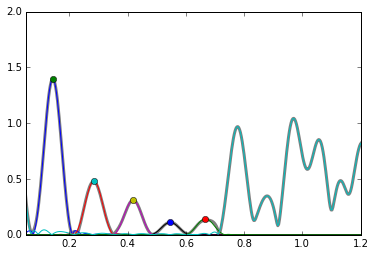

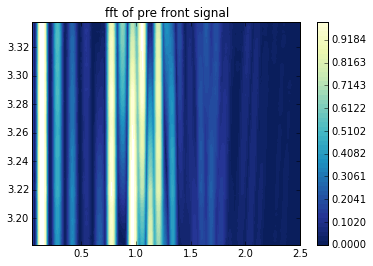

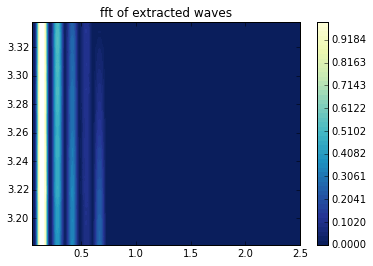

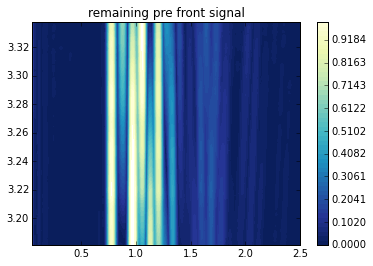

In [606]:
presignal = r.U[:, :, 300:3300].mean(axis=0)

pre_combed_waves = extract_waves(data=presignal, nf=5, window='hanning', plots=True)

plt.figure()
plt.title('fft of pre front signal')
contour_fft(presignal)
plt.colorbar()

plt.figure()
plt.title('fft of extracted waves')
contour_fft(pre_combed_waves[:, :3000])
plt.colorbar()

plt.figure()
plt.title('remaining pre front signal')
contour_fft(presignal - pre_combed_waves[:, :3000])
plt.colorbar()

In [7]:
dx = r.X[0, 1, 0] - r.X[0, 0, 0]
shear = 1 / (r.front_speed.value * r.dt / dx)

Aa = np.array([[1, 0, 0],
               [0, 1, 0],
               [0, shear, 1]])

iAa = np.array([[1, 0, 0],
                [0, 1, 0],
                [0, -shear, 1]])

tra = ndi.affine_transform(r.U[:, :, :], Aa, order=0, cval=np.nan)
mtra = tra.mean(axis=1, keepdims=1)
m_sub = ndi.affine_transform(tra - mtra, iAa, order=0, cval=np.nan)

In [8]:
valid_mean_subtracted = m_sub[:, :, 300:8300]
msm = valid_mean_subtracted.mean(axis=0)

In [9]:
def mean_waves():
    signal = bandpass(msm, 0.7, axis=-1)
    return signal.mean(axis=0)

def fft_waves(index):
    signal = bandpass(msm, 0.7, axis=-1)
    fft = fftpack.rfft(signal, axis=0)
    fft[index:, :] = 0
    return fftpack.irfft(fft, axis=0)

def dct_waves(index, signal=msm, dct_type=2, axis=0, cutoff=0.7):
    if cutoff:
        signal = bandpass(signal, cutoff, axis=-1)
    dct = fftpack.dct(signal, axis=axis, type=dct_type, norm='ortho')
    where = [slice(None) for _ in dct.shape]
    where[axis] = slice(index, None)
    dct[where] = 0
    return fftpack.idct(dct, type=dct_type, axis=axis, norm='ortho')

def dst_waves(index, dst_type=2):
    signal = bandpass(msm, 0.7, axis=-1)
    udst = fftpack.dst(signal, axis=0, type=dst_type, norm='ortho')
    udst[index:, :] = 0
    return fftpack.idst(udst, type=dst_type, axis=0, norm='ortho')

import numpy.testing as npt

npt.assert_array_almost_equal(mean_waves(), fft_waves(1)[0], decimal=15)
npt.assert_array_almost_equal(mean_waves(), dct_waves(1)[0], decimal=15)

In [437]:
window = sig.hanning(8000)
msize = 2 ** 15

ffta = np.fft.rfft(msm * window, msize, axis=-1)
fftb = np.fft.rfft(fft_waves(2) * window, msize, axis=-1)
fftd = np.fft.rfft(dct_waves(2, cutoff=0.6) * window, msize, axis=-1)

fftr = np.fft.rfft((msm - fft_waves(2)) * window, msize, axis=-1)
fftrd = np.fft.rfft((msm - dct_waves(2, cutoff=0.6)) * window, msize, axis=-1)

(0.05, 3)

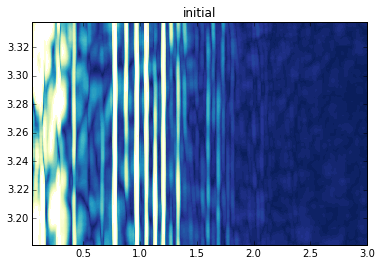

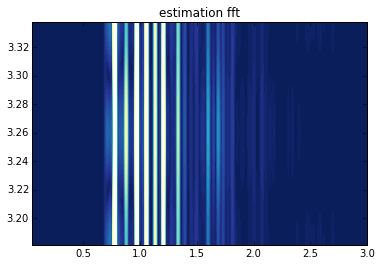

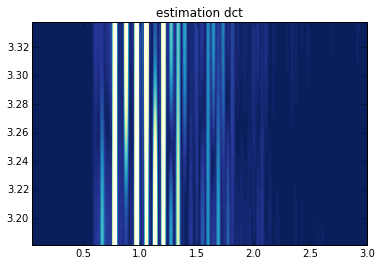

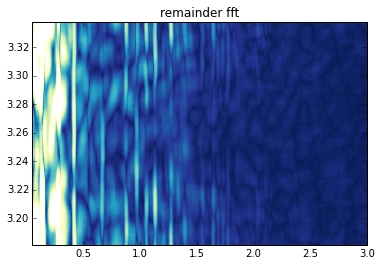

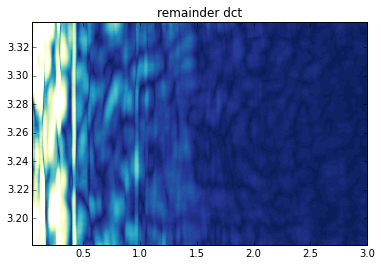

In [438]:
cmap = plt.cm.YlGnBu_r
lvl = np.linspace(0, 1, 50)
xlim = (0.05, 3)

x = r.X[0, :, 0]
freqs = np.fft.rfftfreq(msize, d=0.01)
Ff, Xf = np.meshgrid(freqs, x)

which = (freqs > xlim[0]) & (freqs < xlim[1])
F = Ff[:, which]
X = Xf[:, which]

plt.figure()
plt.title('initial')
plt.contourf(F, X, np.abs(ffta[:, which]), levels=lvl, cmap=cmap)
plt.xlim(*xlim)

plt.figure()
plt.title('estimation fft')
plt.contourf(F, X, np.abs(fftb[:, which]), levels=lvl, cmap=cmap)
plt.xlim(*xlim)

plt.figure()
plt.title('estimation dct')
plt.contourf(F, X, np.abs(fftd[:, which]), levels=lvl, cmap=cmap)
plt.xlim(*xlim)

plt.figure()
plt.title('remainder fft')
plt.contourf(F, X, np.abs(fftr[:, which]), levels=lvl, cmap=cmap)
plt.xlim(*xlim)

plt.figure()
plt.title('remainder dct')
plt.contourf(F, X, np.abs(fftrd[:, which]), levels=lvl, cmap=cmap)
plt.xlim(*xlim)

(0, 1)

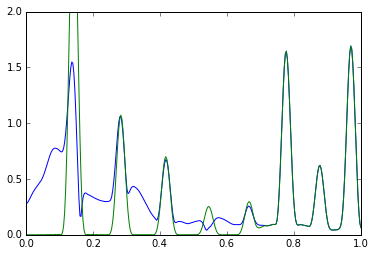

In [389]:
plot_total_fft(dct_waves(2, cutoff=0.01), window='blackman')
plot_total_fft(all_waves, window='blackman')
plt.ylim(0, 2)
plt.xlim(0, 1)

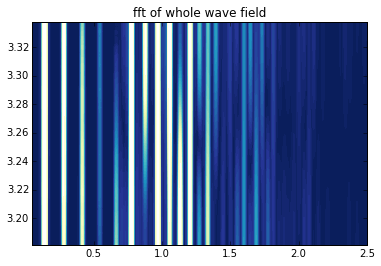

In [12]:
all_waves = pre_combed_waves + dct_waves(2)
contour_fft(all_waves, xlim=(0.05, 2.5))
plt.title('fft of whole wave field')

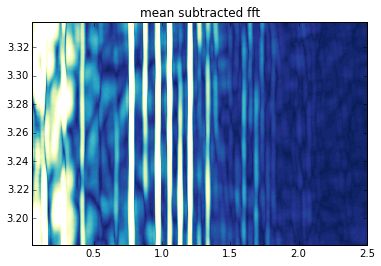

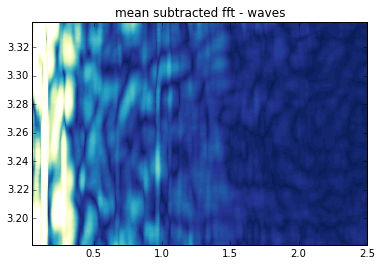

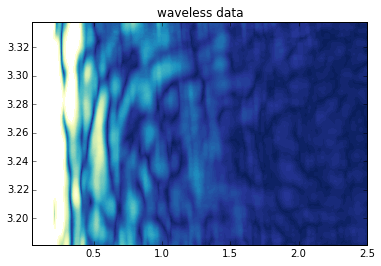

In [13]:
plt.figure()
plt.title('mean subtracted fft')
contour_fft(msm, xlim=(0.05, 2.5))

# note how the waves are not removed below fcrit. msm is from the data without the pre waves subtracted.
# These waves pass through the mean subtraction with a change of phase.
plt.figure()
plt.title('mean subtracted fft - waves')
contour_fft(msm - all_waves, xlim=(0.05, 2.5))

plt.figure()
plt.title('waveless data')
contour_fft((r.U[:, :, 300:8300].mean(axis=0) - all_waves), xlim=(0.05, 2.5))

In [16]:
# calculate the frequency below which we expect periodic features to not be averaged out by mean subtraction.
c = r.front_speed.value
fcrit = c / (x.max() - x.min())

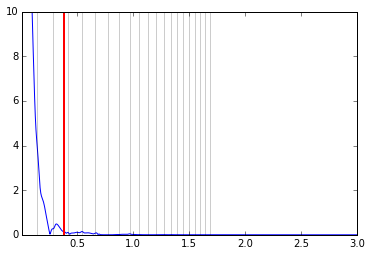

In [20]:
plot_smooth_fft((r.U[:, :, 300:8300].mean(axis=0) - all_waves).mean(axis=0))
plot_all_frequencies(20, color='k', alpha=0.2)
plt.xlim(0.01, 3)
plt.ylim(0, 10)
plt.xscale('linear')
plt.axvline(fcrit, color='r', linewidth=2)

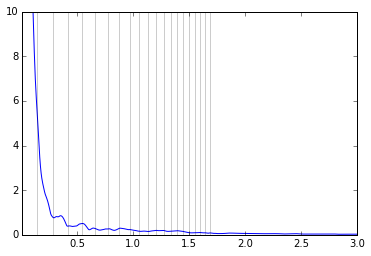

In [22]:
def plot_total_fft(signal, xlim=(0.01, 3), ylim=(0, 10), window='hanning', size=2**15):
    window = sig.get_window(window, signal.shape[-1], fftbins=False)

    rfft = np.fft.rfft(signal * window, n=size, axis=-1)
    freqs = np.fft.rfftfreq(size, d=0.01)

    plt.plot(freqs, np.abs(rfft).mean(axis=0))
    plt.xlim(*xlim)
    plt.ylim(*ylim)

plot_total_fft(r.U[:, :, 300:8300].mean(axis=0) - all_waves)

plot_all_frequencies(20, color='k', alpha=0.2)

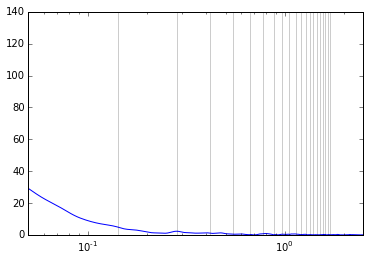

In [23]:
plot_smooth_fft(r.U[10, 0, 300:8300] - all_waves[0])
plot_all_frequencies(20, color='k', alpha=0.2)

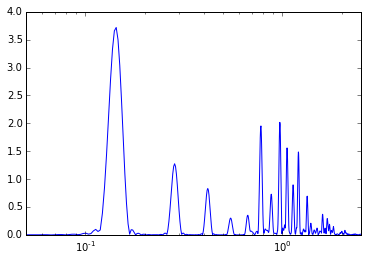

In [24]:
plot_smooth_fft(all_waves.mean(axis=0))

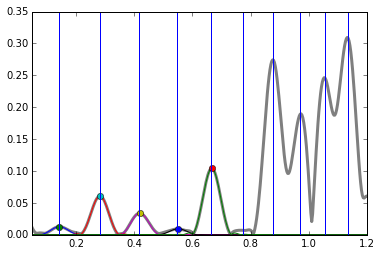

In [25]:
prew = r.W[:, :, 300:3300].mean(axis=0)

prew_combed_waves = extract_waves(data=prew, nf=5, window='hanning', plots=True)
plot_all_frequencies(20)

In [747]:
tra = ndi.affine_transform(r.W[:, :, :], Aa, order=0, cval=np.nan)
mtra = tra.mean(axis=1, keepdims=1)
m_sub_w = ndi.affine_transform(tra - mtra, iAa, order=0, cval=np.nan)

In [748]:
valid_mean_subtracted_w = m_sub_w[:, :, 300:8300]
msmw = valid_mean_subtracted[:].mean(axis=0)

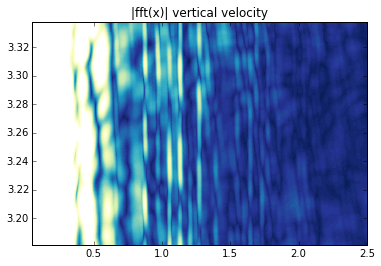

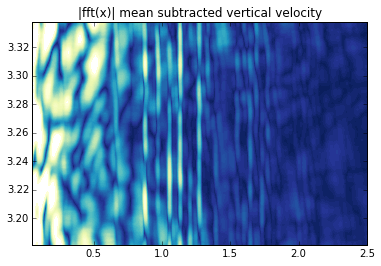

In [749]:
plt.figure()
plt.title('|fft(x)| vertical velocity')
contour_fft(r.W[:, :, 300:8300].mean(axis=0), xlim=(0.05, 2.5))

plt.figure()
plt.title('|fft(x)| mean subtracted vertical velocity')
contour_fft(valid_mean_subtracted_w.mean(axis=0), xlim=(0.05, 2.5))

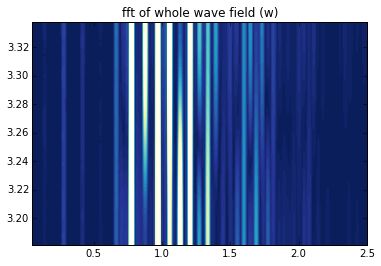

In [750]:
all_waves_w = prew_combed_waves + dct_waves(2, signal=msmw)
contour_fft(all_waves_w, xlim=(0.05, 2.5))
plt.title('fft of whole wave field (w)')

In [762]:
def vertical_profile(signal, subtract_mean=True):
    """Vertical profile of velocity, normalised to the mean."""
    if subtract_mean:
        signal -= signal.mean(axis=-1)[..., None]
    return np.abs(signal.mean(axis=1)).mean(axis=-1) / np.abs(signal.mean(axis=1)).mean()

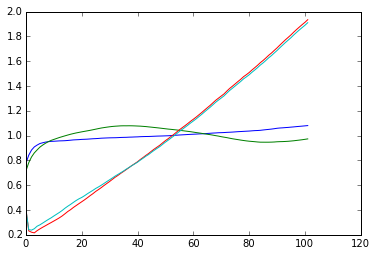

In [765]:
plt.plot(vertical_profile(r.U[:, :, :3000]))
plt.plot(vertical_profile(r.U[:, :, :3000], subtract_mean=False))

plt.plot(vertical_profile(r.W[:, :, :3000]))
plt.plot(vertical_profile(r.W[:, :, :3000], subtract_mean=False))

In [755]:
vertical_w = vertical_profile(r.W[:, :, :3000])[:, None, None]
dvwaves =  vertical_w * dct_waves(index=3, signal=r.W[:, :, 300:8300].mean(axis=0), axis=0)

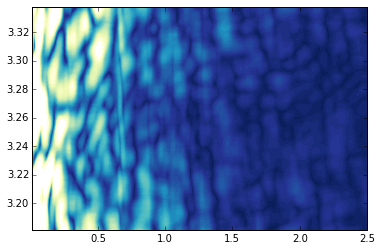

In [756]:
contour_fft((valid_mean_subtracted_w - dvwaves).mean(axis=0), xlim=(0.01, 2.5))

In [369]:
all_waves_wz = vertical_w * prew_combed_waves + dvwaves

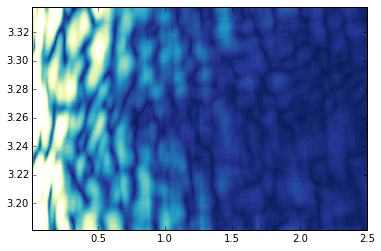

In [371]:
contour_fft((valid_mean_subtracted_w - all_waves_wz).mean(axis=0), xlim=(0.01, 2.5))

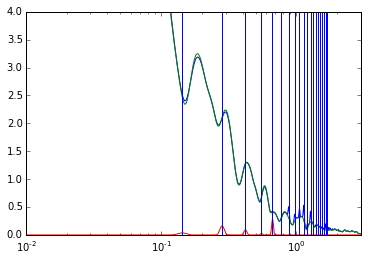

In [387]:
plot_total_fft(r.W[:, :, 300:8300].mean(axis=0))
plot_total_fft((r.W[:, :, 300:8300] - all_waves_wz).mean(axis=0))
plot_smooth_fft(prew_combed_waves.mean(axis=0))

plt.ylim(0, 4)
plot_all_frequencies(20)

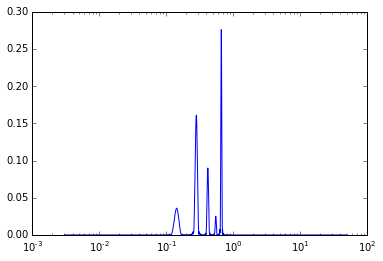

In [383]:
plot_smooth_fft(prew_combed_waves.mean(axis=0))

(0, 1)

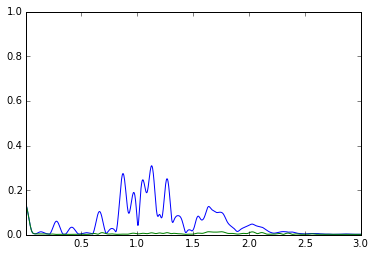

In [386]:
plot_total_fft(r.W[:, :, 300:3300].mean(axis=0))
plot_total_fft((r.W[:, :, 300:8300] - all_waves_wz).mean(axis=0)[:, :3000])

plt.ylim(0, 1)

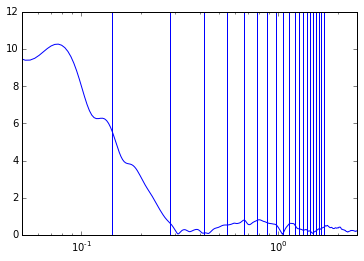

In [391]:
plot_smooth_fft((r.W[:, :, 300:8300] - all_waves_wz)[-10, 10])
plt.xlim(0.05, 2.5)
plot_all_frequencies(20)

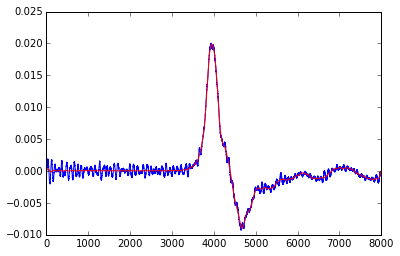

In [395]:
plt.plot(r.W[:, :, 300:8300].mean(axis=0).mean(axis=0))
plt.plot((r.W[:, :, 300:8300] - all_waves_wz).mean(axis=0).mean(axis=0), 'r')

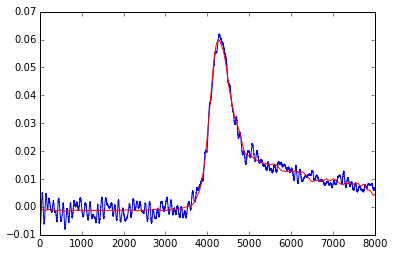

In [397]:
plt.plot(r.U[:, :, 300:8300].mean(axis=0).mean(axis=0))
plt.plot((r.U[:, :, 300:8300] - all_waves).mean(axis=0).mean(axis=0), 'r')

(0, 1)

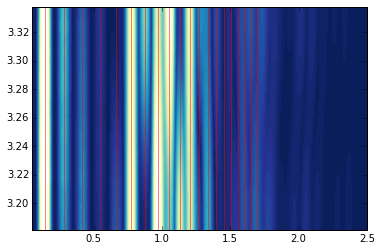

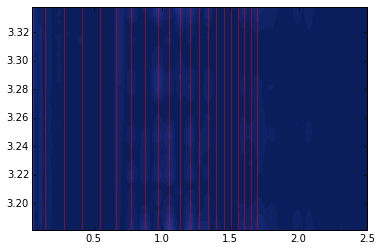

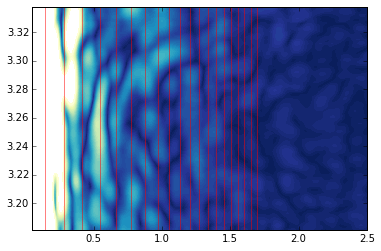

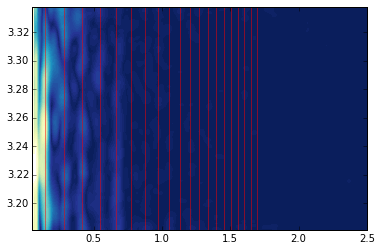

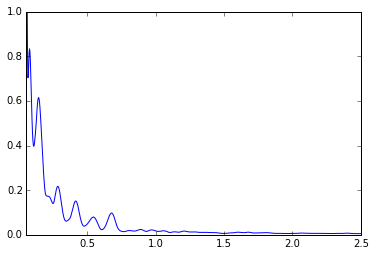

In [439]:
plt.figure()
contour_fft((all_waves)[..., :3000], xlim=(0.05, 2.5))
plot_all_frequencies(20, color='r', alpha=0.5)

plt.figure()
contour_fft((r.U[:, :, 300:8300] - all_waves)[..., :3000].mean(axis=0), xlim=(0.05, 2.5))
plot_all_frequencies(20, color='r', alpha=0.5)

plt.figure()
contour_fft((r.U[:, :, 300:8300] - all_waves)[..., 3000:6000].mean(axis=0), xlim=(0.05, 2.5))
plot_all_frequencies(20, color='r', alpha=0.5)

plt.figure()
contour_fft((r.U[:, :, 300:8300] - all_waves)[..., 5000:8000].mean(axis=0), xlim=(0.05, 2.5))
plot_all_frequencies(20, color='r', alpha=0.5)

plt.figure()
plot_total_fft((r.U[:, :, 300:8300] - all_waves)[..., 5000:8000].mean(axis=0), xlim=(0.05, 2.5))
plt.ylim(0, 1)

(0, 10)

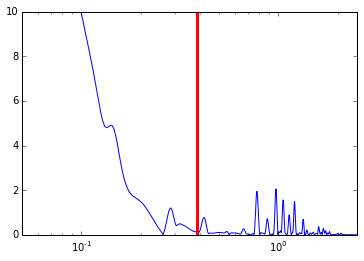

In [444]:
plot_smooth_fft(r.U[:, :, 300:8300].mean(axis=0).mean(axis=0))
plt.axvline(fcrit, color='r', linewidth=3)
plt.ylim(0, 10)

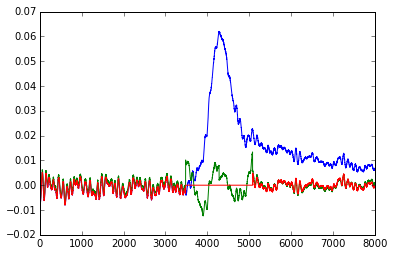

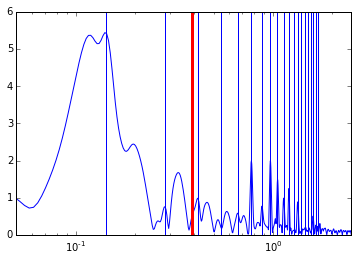

In [77]:
u = r.U[:, :, 300:8300].mean(axis=0).mean(axis=0)
#u[3500:4800] = 0
#u[4800:] = sig.detrend(u[4800:])
mu = u.argmax()
ud = sig.detrend(u, bp=(mu - 800, u.argmax(), mu + 800))

def quadratic_detrend(signal):
    x = np.arange(signal.size)
    model = np.polyfit(x, signal, 2)
    return signal - np.polyval(model, x)

udq = u.copy()
udq[mu - 800: mu + 800] = 0
udq[mu + 800:] = quadratic_detrend(ud[mu + 800:])

plt.plot(u)
plt.plot(ud)
plt.plot(udq)

plt.figure()
plot_smooth_fft(ud)
plot_all_frequencies(20)
plt.axvline(fcrit, color='r', linewidth=3)

Need to find a way to get a better estimate of the frequency / phase of the pre frontal elements. The current method isn't doing it well enough and this leads to the waves not being exactly cancelled at the end of the signal.

Could take calculated wave as first guess and try and minimise the entire signal, or detrended signal.

Could use amplitude as given and vary frequency so that final third of signal is minimised.

Need to work out whether frequency or phase or both are out.

Another thing it could be: decay of the wave amplitude over time.

This appears to be the case.

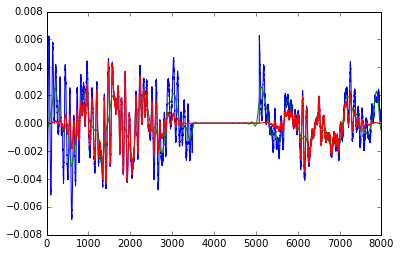

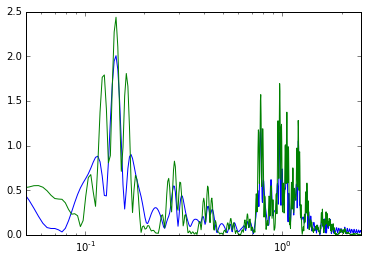

In [49]:
ud[mu - 800: mu + 800] = 0
plt.plot(ud)
plt.plot(bandpass(ud, 0, 0.7))

w1 = sig.hanning(mu - 800)
w2 = sig.hanning(u.size - (mu + 800))
udw = ud.copy()
udw[:mu - 800] *= w1
udw[mu + 800:] *= w2
plt.plot(udw)

plt.figure()
plot_smooth_fft(ud)
plot_smooth_fft(udw, window='boxcar')

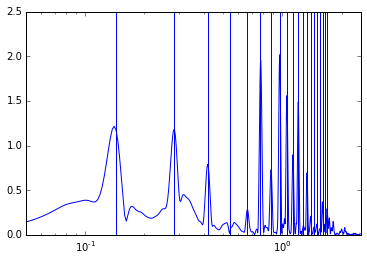

In [435]:
plot_smooth_fft(m_sub[..., 300:8300].mean(axis=0).mean(axis=0))
plot_all_frequencies(20)

In [675]:
def construct_wave(amplitude, f, length, decay=0, dt=0.01):
    t = np.arange(length) * dt
    return amplitude * np.exp(2j * np.pi * f * t) * np.exp(decay * t)

def wave_fft(amplitude, f, size, window, decay=0):
    wave = (2 / window.sum()) * construct_wave(amplitude, f, window.size, decay=decay) * window
    return np.fft.rfft(wave, size)

def subtract_amplitude_fft(fft, amplitude, f, size, window, decay=0):
    return fft - wave_fft(amplitude, f, size, window, decay=decay)


def minimise_this_decay((amplitude, f, phase, decay), fft, size, window):
    amplitude = amplitude * np.exp(1j * phase)
    return np.linalg.norm(subtract_amplitude_fft(fft, amplitude, f, size, window, decay=decay))


def minimise_power_decay(f, fft, freqs, size, window, bounds=None):
    power = np.abs(fft)
    peak = find_closest_peaks(power, np.array(freqs), guess_freqs=np.array([f]))
    idx = np.abs(freqs - f).argmin()
    
    idx = peak
    
    amplitude = power[idx]
    # get phase from the fft (assume it doesn't change)
    phase = np.angle(fft[idx])
        
    if bounds is not None:
        dp = 2
        bounds = [(amplitude * 0.5, amplitude * 1.5), bounds, (-np.pi, np.pi), (-0.02, -0.002)]
    minim = opt.minimize(minimise_this_decay, 
                         #method='TNC', 
                         x0=(amplitude, freqs[peak], phase, -0.007), 
                         args=(fft, size, window),
                         bounds=bounds)
                         
    opt_amplitude = minim.x[0]
    opt_freq = minim.x[1]
    opt_phase = minim.x[2]
    opt_decay = minim.x[3]
    
    camplitude = opt_amplitude * np.exp(1j * opt_phase)
    
    return camplitude, opt_freq, opt_decay, wave_fft(camplitude, opt_freq, size, window, opt_decay)

def comb_frequencies_decay(fft, nf, window, size, df=0.01, plots=False):
    freqs = np.fft.rfftfreq(size, d=0.01)
    
    amplitudes = np.zeros(nf, np.complex)
    frequencies = np.zeros(nf, np.float)
    decay = np.zeros(nf, np.float)
    peak_ffts = np.zeros((nf, freqs.size), np.complex)
    
    if plots:
        plt.plot(freqs, np.abs(fft), 'k', linewidth=3, alpha=0.5)
    # go through each guess frequency and find the nearest wave 
    # amplitude (complex) and frequency that would minimise the 
    # power spectrum, subtracting the optimal wave each time.
    for i, f in enumerate(full_frequency(np.arange(1, nf + 1))):
        amplitudes[i], frequencies[i], decay[i], peak_ffts[i] = minimise_power_decay(f, fft, freqs, size, window, 
                                                                                     bounds=(f-df,f+df))
        fft = fft - peak_ffts[i]
        
        if plots:
            plt.plot(freqs, np.abs(peak_ffts[i]))
            plt.plot(frequencies[i], np.abs(amplitudes[i]), 'o')
            plt.annotate(round(decay[i], 4), 
                         xy=(frequencies[i], np.abs(amplitudes[i])), 
                         xytext=(frequencies[i] / (1.2 - 0.05), 1 - 0.1 * (i + 1)),
                         textcoords='axes fraction',
                         arrowprops=dict(facecolor='black', shrink=0.05))
            plt.xlim(0.05, 1.2)
            
    if plots:
        plt.plot(freqs, np.abs(fft))
        
    return amplitudes, frequencies.real, decay, peak_ffts


def extract_waves_decay(data, nf, size=2**15, window='hanning', plots=False):
    x = r.X[0, :, 0]
    freqs = np.fft.rfftfreq(size, d=0.01)
    window = sig.get_window(window, data.shape[-1], fftbins=False)
    
    fft = np.fft.rfft(data * window, n=size, axis=-1)
    
    
    amplitudes, frequencies, decay, peak_ffts = comb_frequencies_decay(fft.mean(axis=0), nf=nf, window=window, size=size, plots=plots)

    iamp = interp.RectBivariateSpline(x, freqs, np.abs(fft))
    amplitude_variation = iamp(x, frequencies[:nf])
    
    plt.figure()
    plt.plot(amplitude_variation, '--')
    dct = fftpack.dct(amplitude_variation, axis=0, norm='ortho')
    dct[3:] = 0
    amplitude_variation = fftpack.idct(dct, axis=0, norm='ortho')
    plt.plot(amplitude_variation)
    
    # scale the amplitude variation to its mean
    amplitude_variation /= amplitude_variation.mean(axis=0)
    
    full_amplitudes = amplitudes * amplitude_variation
    
    return (2 / window.sum()) * construct_wave(full_amplitudes[..., None], 
                                               frequencies[:nf, None], 
                                               length=8000,
                                               decay=decay[:nf, None]).real.sum(axis=1)

In [676]:
def minimise_this_decay((amplitude_re, f, amplitude_im, decay), fft, size, window):
    amplitude = np.complex(amplitude_re, amplitude_im)
    return np.linalg.norm(subtract_amplitude_fft(fft, amplitude, f, size, window, decay=decay))


def minimise_power_decay(f, fft, freqs, size, window, bounds=None):
    power = np.abs(fft)
    peak = find_closest_peaks(power, np.array(freqs), guess_freqs=np.array([f]))
    idx = np.abs(freqs - f).argmin()
    
    idx = peak
    
    amplitude = power[idx]
    # get phase from the fft (assume it doesn't change)
    phase = np.angle(fft[idx])
    
    amplitude = fft[idx]
        
    if bounds is not None:
        damp = np.abs(amplitude) * 0.3
        bounds = [(amplitude.real - damp, amplitude.real + damp), 
                  bounds, 
                  (amplitude.imag - damp, amplitude.imag + damp), 
                  (-0.02, -0.002)]
    minim = opt.minimize(minimise_this_decay, 
                         #method='TNC', 
                         x0=(amplitude.real, freqs[peak], amplitude.imag, -0.007), 
                         args=(fft, size, window),
                         bounds=bounds)
                         
    opt_amplitude_re = minim.x[0]
    opt_freq = minim.x[1]
    opt_amplitude_im = minim.x[2]
    opt_decay = minim.x[3]
    
    camplitude = np.complex(opt_amplitude_re, opt_amplitude_im)
        
    return camplitude, opt_freq, opt_decay, wave_fft(camplitude, opt_freq, size, window, opt_decay)

(0.05, 1.2)

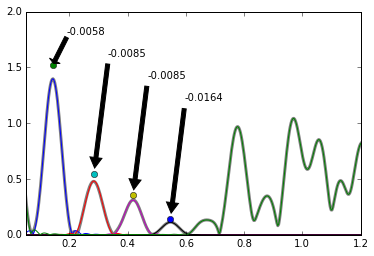

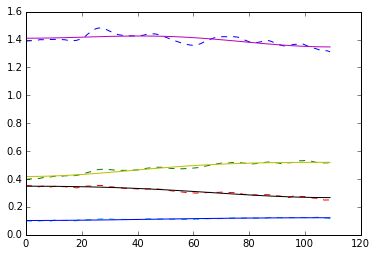

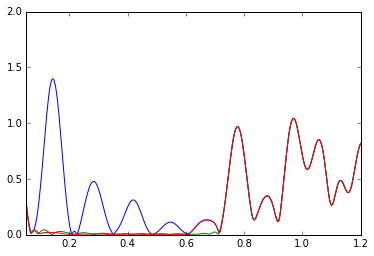

In [726]:
presignal = r.U[:, :, 300:3300].mean(axis=0)
postsignal = quadratic_detrend(r.U[:, :, 5300:8300].mean(axis=0).mean(axis=0))

decay_waves = extract_waves_decay(data=presignal, nf=4, window='hanning', plots=True)

plt.figure()
plot_total_fft(presignal)
plot_total_fft(presignal - pre_combed_waves[:, :3000])
plot_total_fft(presignal - decay_waves[:, :3000])
plt.ylim(0, 2)
plt.xlim(0.05, 1.2)

(0.05, 1.2)

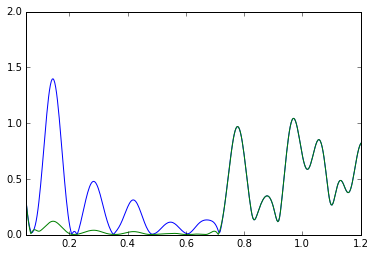

In [644]:
def create_exp_waves(decay):
    return pre_combed_waves * np.exp(-decay * 0.01 * (np.arange(8000)))

exp_waves = create_exp_waves(0.006)

plot_total_fft(presignal)
plot_total_fft((presignal - exp_waves[:, :3000]))
plt.ylim(0, 2)
plt.xlim(0.05, 1.2)

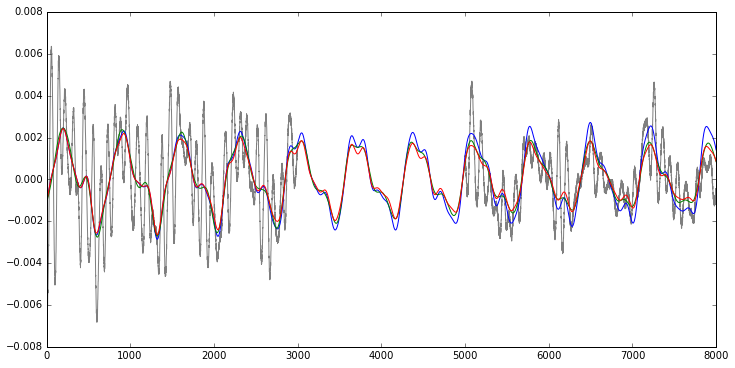

In [678]:
plt.figure(figsize=(12, 6))
plt.plot(presignal.mean(axis=0) - presignal.mean(), alpha=0.5, color='k')
plt.plot(np.arange(5000, 8000), postsignal, alpha=0.5, color='k')

plt.plot(pre_combed_waves.mean(axis=0))
plt.plot(decay_waves.mean(axis=0))
plt.plot(exp_waves.mean(axis=0))

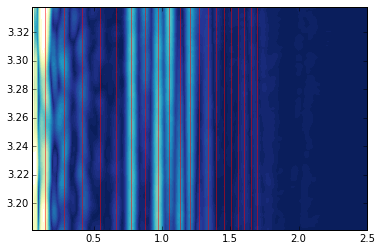

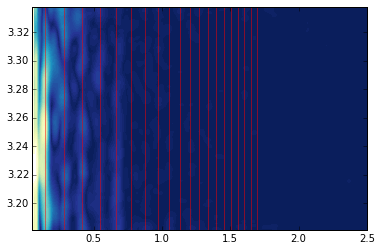

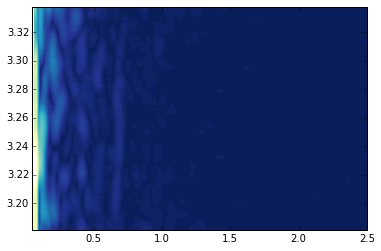

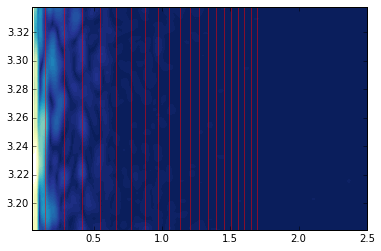

In [679]:
plt.figure()
contour_fft((r.U[:, :, 300:8300])[..., 5000:8000].mean(axis=0), xlim=(0.05, 2.5))
plot_all_frequencies(20, color='r', alpha=0.5)

plt.figure()
contour_fft((r.U[:, :, 300:8300] - all_waves)[..., 5000:8000].mean(axis=0), xlim=(0.05, 2.5))
plot_all_frequencies(20, color='r', alpha=0.5)

plt.figure()
contour_fft((r.U[:, :, 300:8300] - exp_waves - dct_waves(3))[..., 5000:8000].mean(axis=0), xlim=(0.05, 2.5))
#plot_all_frequencies(20, color='r', alpha=0.5)

plt.figure()
contour_fft((r.U[:, :, 300:8300] - decay_waves - dct_waves(3, cutoff=0.6))[..., 5000:8000].mean(axis=0), xlim=(0.05, 2.5))
plot_all_frequencies(20, color='r', alpha=0.5)

(0, 1)

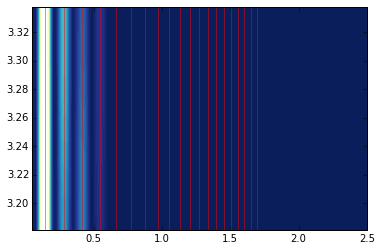

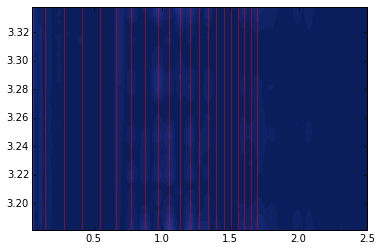

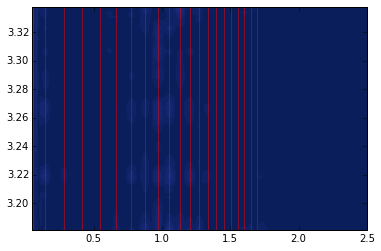

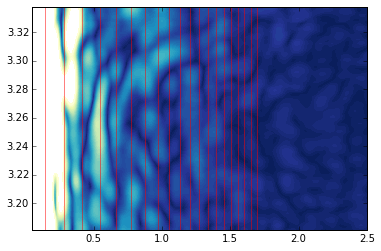

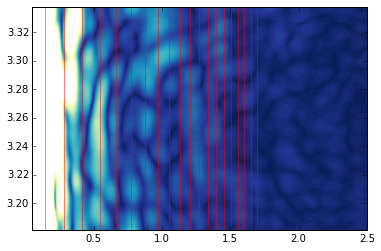

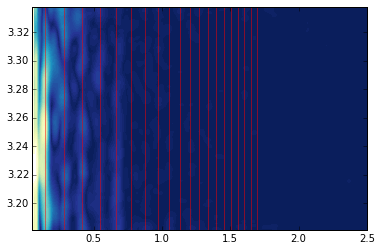

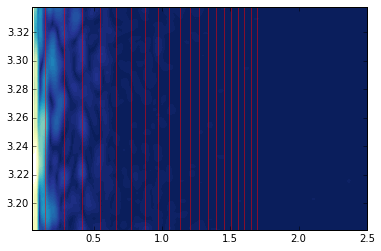

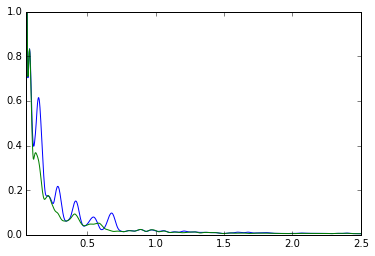

In [680]:
plt.figure()
contour_fft((decay_waves)[..., :3000], xlim=(0.05, 2.5))
plot_all_frequencies(20, color='r', alpha=0.5)


plt.figure()
contour_fft((r.U[:, :, 300:8300] - all_waves)[..., :3000].mean(axis=0), xlim=(0.05, 2.5))
plot_all_frequencies(20, color='r', alpha=0.5)

plt.figure()
contour_fft((r.U[:, :, 300:8300] - decay_waves - dct_waves(3, cutoff=0.6))[..., :3000].mean(axis=0), xlim=(0.05, 2.5))
plot_all_frequencies(20, color='r', alpha=0.5)


plt.figure()
contour_fft((r.U[:, :, 300:8300] - all_waves)[..., 3000:6000].mean(axis=0), xlim=(0.05, 2.5))
plot_all_frequencies(20, color='r', alpha=0.5)

plt.figure()
contour_fft((r.U[:, :, 300:8300] - decay_waves - dct_waves(3, cutoff=0.6))[..., 3000:6000].mean(axis=0), xlim=(0.05, 2.5))
plot_all_frequencies(20, color='r', alpha=0.5)


plt.figure()
contour_fft((r.U[:, :, 300:8300] - all_waves)[..., 5000:8000].mean(axis=0), xlim=(0.05, 2.5))
plot_all_frequencies(20, color='r', alpha=0.5)

plt.figure()
contour_fft((r.U[:, :, 300:8300] - decay_waves - dct_waves(3, cutoff=0.6))[..., 5000:8000].mean(axis=0), xlim=(0.05, 2.5))
plot_all_frequencies(20, color='r', alpha=0.5)


plt.figure()
plot_total_fft((r.U[:, :, 300:8300] - all_waves)[..., 5000:8000].mean(axis=0), xlim=(0.05, 2.5))
plot_total_fft((r.U[:, :, 300:8300] - decay_waves - dct_waves(3, cutoff=0.6))[..., 5000:8000].mean(axis=0), xlim=(0.05, 2.5))
plt.ylim(0, 1)

8.09930466133e-05


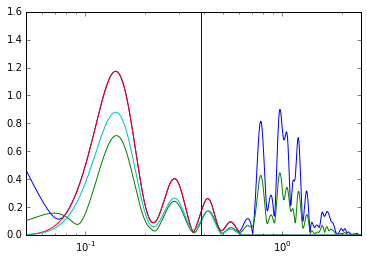

In [611]:
a = np.log(1 / 0.667) / (6500 - 1500)
print a
plot_smooth_fft(presignal.mean(axis=0), window='blackman')
plot_smooth_fft(postsignal, window='blackman')

plot_smooth_fft(decay_waves.mean(axis=0)[:3000], window='blackman')
plot_smooth_fft(decay_waves.mean(axis=0)[-3000:], window='blackman')
plt.axvline(fcrit)

(0, 1)

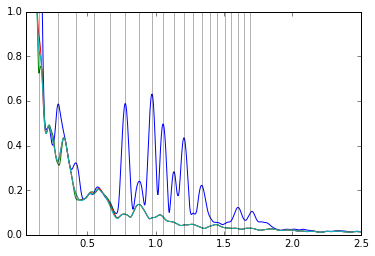

In [681]:
plt.figure()
where = np.s_[..., 4000:7000]
plot_total_fft((r.U[:, :, 300:8300])[where].mean(axis=0), xlim=(0.05, 2.5))

plot_total_fft((r.U[:, :, 300:8300] - pre_combed_waves - dct_waves(3))[where].mean(axis=0), xlim=(0.05, 2.5))
plot_total_fft((r.U[:, :, 300:8300] - decay_waves - dct_waves(3, cutoff=0.6))[where].mean(axis=0), xlim=(0.05, 2.5))

plot_all_frequencies(20, alpha=0.3, color='k')

plt.ylim(0, 1)

(0, 1)

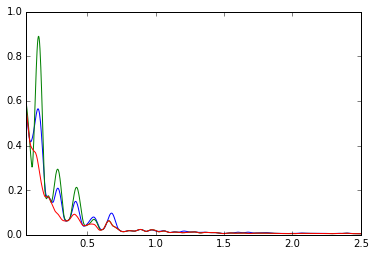

In [683]:
plt.figure()
plot_total_fft(sig.detrend((r.U[:, :, 300:8300] - all_waves)[..., 5000:8000].mean(axis=0)), xlim=(0.05, 2.5))
plot_total_fft(sig.detrend((r.U[:, :, 300:8300] - dct_waves(3))[..., 5000:8000].mean(axis=0)), xlim=(0.05, 2.5))
plot_total_fft(sig.detrend((r.U[:, :, 300:8300] - decay_waves - dct_waves(3))[..., 5000:8000].mean(axis=0)), xlim=(0.05, 2.5))
plt.ylim(0, 1)

(0, 1)

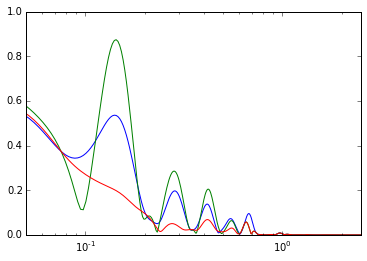

In [684]:
plt.figure()
plot_smooth_fft(sig.detrend((r.U[:, :, 300:8300] - all_waves)[..., 5000:8000].mean(axis=0).mean(axis=0)))
plot_smooth_fft(sig.detrend((r.U[:, :, 300:8300] - dct_waves(3))[..., 5000:8000].mean(axis=0).mean(axis=0)))
plot_smooth_fft(sig.detrend((r.U[:, :, 300:8300] - decay_waves - dct_waves(3))[..., 5000:8000].mean(axis=0).mean(axis=0)))

plt.ylim(0, 1)

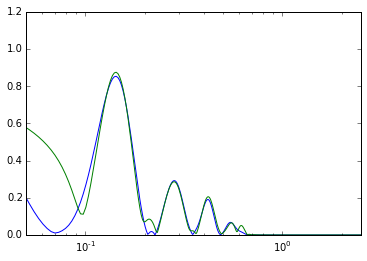

In [394]:
bpre = bandpass(presignal.mean(axis=0), 0, 0.6)
bpost = bandpass(postsignal, 0, 0.6)

plot_smooth_fft(bpre * 0.61)
plot_smooth_fft(bpost)

In [399]:
nr = 2 * full_frequency(2) * 50 / 2
rf = np.exp(np.log(0.61) / nr)

In [431]:
print rf
print '----'
print np.log(1 / rf ** (2 * 50 * full_frequency(1) / 1)) / 50
print np.log(1 / rf ** (2 * 50 * full_frequency(2) / 2)) / 50
print np.log(1 / rf ** (2 * 50 * full_frequency(3) / 3)) / 50

0.965628466875
----
0.00998487231839
0.0098859264363
0.00972900817053


In [401]:
0.61 / 5000

0.000122

(0.05, 1.2)

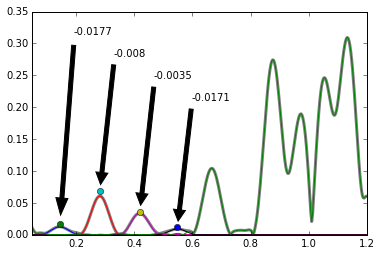

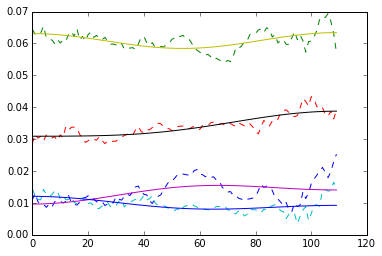

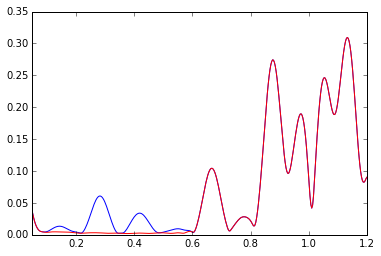

In [725]:
presignal_w = r.W[:, :, 300:3300].mean(axis=0)

decay_waves_w = extract_waves_decay(data=presignal_w, nf=4, window='hanning', plots=True)

plt.figure()
plot_total_fft(presignal_w)
plot_total_fft(presignal_w - prew[:, :3000])
plot_total_fft(presignal_w - decay_waves_w[:, :3000])
plt.ylim(0, 0.35)
plt.xlim(0.05, 1.2)

In [717]:
vertical_u = vertical_profile(r.U[:, :, :3000])[:, None, None]

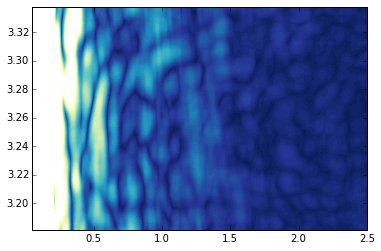

In [729]:
contour_fft((r.U[:, :, 300:8300] - vertical_u * (decay_waves + dct_waves(3, cutoff=0.6))).mean(axis=0))

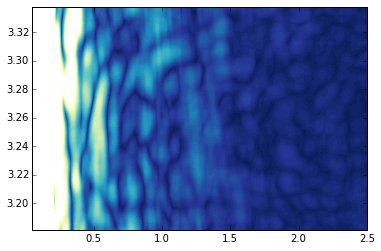

In [728]:
contour_fft((r.U[:, :, 300:8300] - (decay_waves + dct_waves(3, cutoff=0.6))).mean(axis=0))

(0, 0.1)

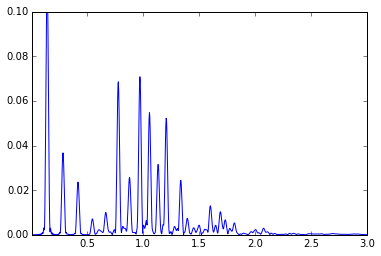

In [737]:
plot_total_fft(((vertical_u - 1) * (decay_waves + dct_waves(3, cutoff=0.6))).mean(axis=1))
plt.ylim(0, 0.1)

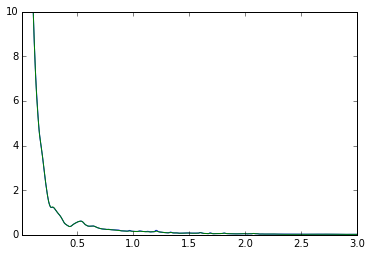

In [739]:
plot_total_fft((r.U[:, :, 300:8300] - (decay_waves + dct_waves(3, cutoff=0.6))).mean(axis=1))
plot_total_fft((r.U[:, :, 300:8300] - vertical_u * (decay_waves + dct_waves(3, cutoff=0.6))).mean(axis=1))

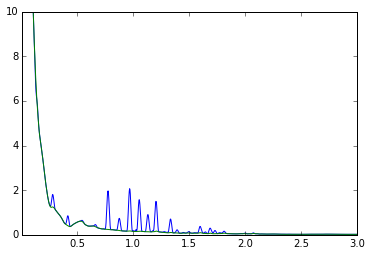

In [743]:
plot_total_fft(((r.U[:, :, 300:8300]).mean(axis=1)))
plot_total_fft((r.U[:, :, 300:8300] - vertical_u * (decay_waves + dct_waves(3, cutoff=0.6))).mean(axis=1))

(0, 3)

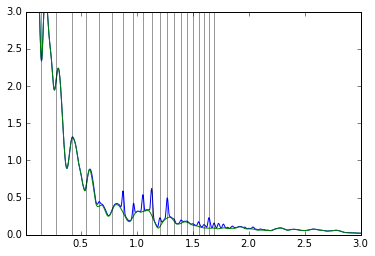

In [794]:
plot_total_fft(((r.W[:, :, 300:8300]).mean(axis=0)))
#plot_total_fft((r.W[:, :, 300:8300] - vertical_w * (decay_waves_w + dct_waves(index=3, signal=msmw))).mean(axis=0))
plot_total_fft((r.W[:, :, 300:8300] - vertical_w * (decay_waves_w + dct_waves(index=3, cutoff=0.6, signal=r.W[:, :, 300:8300].mean(axis=0)))).mean(axis=0))
plot_all_frequencies(20, color='k', alpha=0.4)
plt.ylim(0, 3)

(0, 0.5)

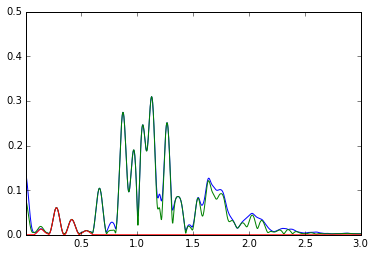

In [796]:
#plot_total_fft(msmw[:, 300:3300])
plot_total_fft(presignal_w)
plot_total_fft(r.W[:, :, 300:3300].mean(axis=1))

plot_total_fft(decay_waves_w[:, :3000])

plt.ylim(0, 0.5)

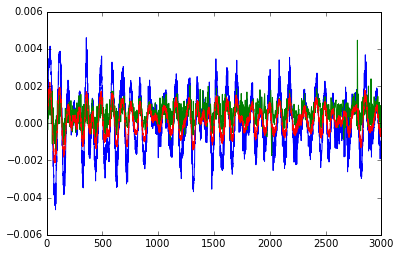

In [788]:
plt.plot(r.W[-1, 0, 300:3300])
#plt.plot(r.W[-20, 0, 300:3300])
#plt.plot(r.W[-40, 0, 300:3300])
#plt.plot(r.W[-60, 0, 300:3300])
plt.plot(r.W[-80, 0, 300:3300])
plt.plot(r.W[:, 0, 300:3300].mean(axis=0))

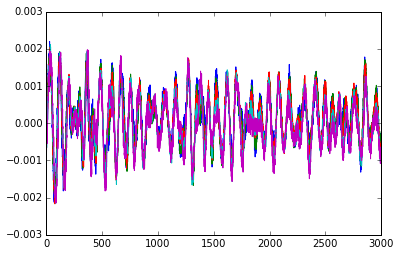

In [795]:
plt.plot(r.W[:, 0, 300:3300].mean(axis=0))
plt.plot(r.W[:, 20, 300:3300].mean(axis=0))
plt.plot(r.W[:, 40, 300:3300].mean(axis=0))
plt.plot(r.W[:, 60, 300:3300].mean(axis=0))
plt.plot(r.W[:, 80, 300:3300].mean(axis=0))

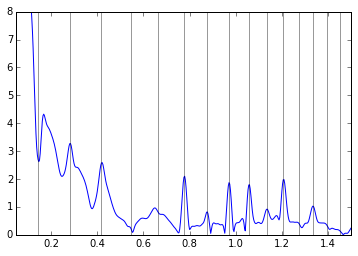

In [814]:
plot_smooth_fft(r.U[10, 80], window='hanning')

plt.ylim(0, 8)
plt.xlim(0.05, 1.5)
plt.xscale('linear')

plot_all_frequencies(20, alpha=0.4, color='k')

In [1004]:
su = r.U[:, :, 300:8300] - r.U[:, :, 300:3300].mean(axis=-1, keepdims=True) - vertical_u * (decay_waves + dct_waves(3, cutoff=0.6))

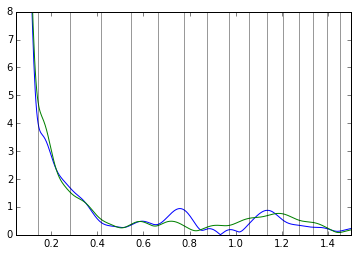

In [1005]:
w = np.s_[20, 20, 3000:5000]

plot_smooth_fft(r.U[..., 300:8300][w])
plot_smooth_fft(su[w])

plt.ylim(0, 8)
plt.xlim(0.05, 1.5)
plt.xscale('linear')

plot_all_frequencies(20, alpha=0.4, color='k')

In [1006]:
afft = np.fft.rfft(sig.hanning(8000) * vertical_u * (decay_waves + dct_waves(2, cutoff=0.6)), n=2**15, axis=-1)

abs_fft = np.abs(afft).mean(axis=0).mean(axis=0)

(0.05, 2.5)

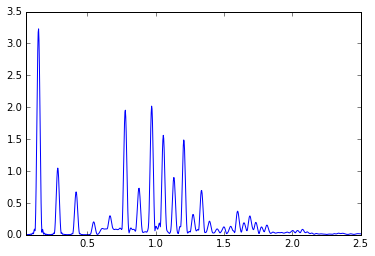

In [1007]:
plt.plot(np.fft.rfftfreq(2**15, d=0.01), abs_fft)
plt.xlim(0.05, 2.5)

<matplotlib.contour.QuadContourSet instance at 0x2af40e5b4368>

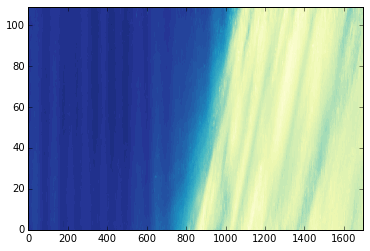

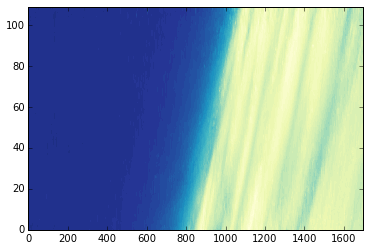

In [1008]:
plt.contourf(r.U[2, :, 3300:5000], 50)

plt.figure()
plt.contourf(su[2, :, 3000:4700], 50)

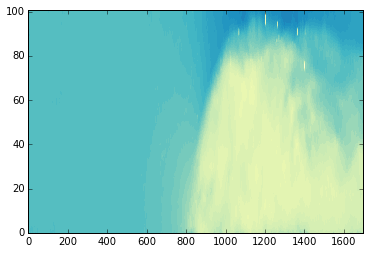

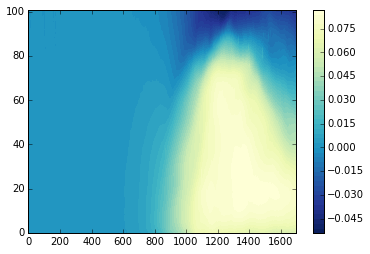

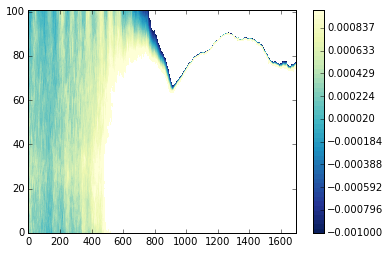

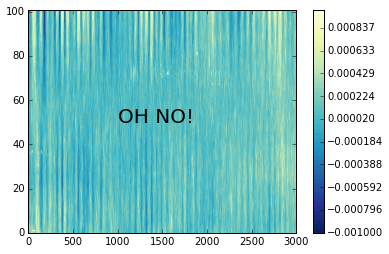

In [1296]:
plt.contourf(su[:, 2, 3000:4700], 50)

plt.figure()
plt.contourf(su[:, :, 3000:4700].mean(axis=1), 50)
plt.colorbar()

plt.figure()
plt.contourf(su[:, :, 3000:4700].mean(axis=1), levels=np.linspace(-0.001, 0.001))
plt.colorbar()

plt.figure()
plt.contourf(su[:, :, :3000].mean(axis=1), levels=np.linspace(-0.001, 0.001))
plt.colorbar()

plt.text(1000, 50, 'OH NO!', fontsize=20)

In [1291]:
def k(n):
    return np.pi * n / L

def vu(z, n):
    H = 0.25
    v = np.cosh(k(n) * z) / np.sinh(k(n) * H)
    return v / v.mean()

def vw(z, n):
    H = 0.25
    v = np.sinh(k(n) * z) / np.sinh(k(n) * H)
    return v / v.mean()

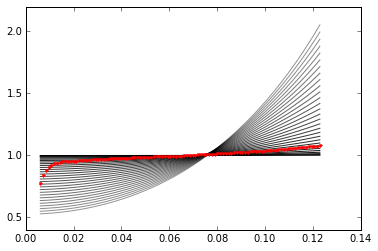

In [1293]:
for n in range(1, 30):
    plt.plot(z, vu(z, n), color='k', alpha=(1 - n / 50.))
    
plt.plot(z, vertical_u.squeeze(), 'r.', linewidth=2)

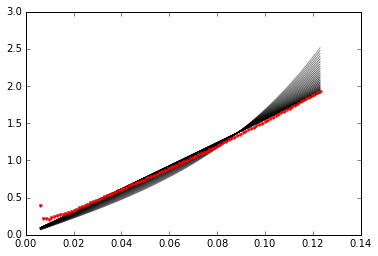

In [1292]:
for n in range(1, 30):
    plt.plot(z, vw(z, n), color='k', alpha=(1 - n / 50.))

plt.plot(z, vertical_w.squeeze(), 'r.', linewidth=2)

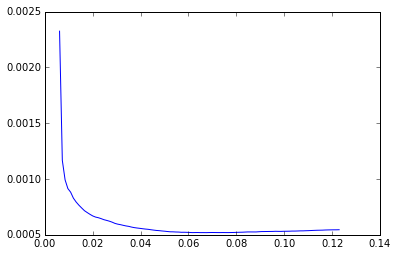

In [904]:
vwr = np.abs(r.W[:, :, :3000].mean(axis=1)).mean(axis=-1)

plt.plot(z, vwr / vw(z, n=1))

We have assumed a constant vertical profile of velocity, whereas this is really a function of frequency. In the low frequency limit the shallow water approximation holds and the (horizontal) velocity amplitude is constant throughout the fluid; in the high frequency limit the fluid is deep and the wave energy is concentrated near the free surface. 

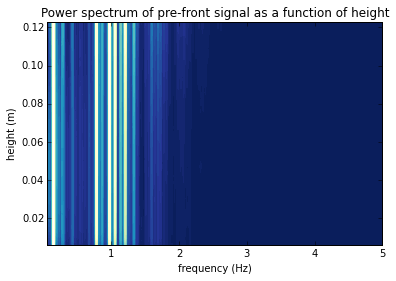

In [1295]:
def z_fft(signal, mean=False, axis=-1, size=2**15, window='hanning', xlim=(0.05, 5)):
    window = sig.get_window(window, signal.shape[axis], fftbins=False)
    
    fft = np.fft.rfft(signal * window, size, axis=axis)
    freqs = np.fft.rfftfreq(size, d=0.01)
    
    cmap = plt.cm.YlGnBu_r
    lvl = np.linspace(0, 2, 50)
    z = r.Z[:, 0, 0]
    Ff, Zf = np.meshgrid(freqs, z)

    which = (freqs > xlim[0]) & (freqs < xlim[1])
    F = Ff[:, which]
    Z = Zf[:, which]
    
    abs_fft = np.abs(fft).mean(axis=1)
    
    if mean:
        abs_fft /= abs_fft.mean(axis=0)
    
    plt.contourf(F, Z, abs_fft[:, which], levels=lvl, cmap=cmap)

plt.title('Power spectrum of pre-front signal as a function of height')
plt.xlabel('frequency (Hz)')
plt.ylabel('height (m)')

z_fft(r.U[:, :, :3000], window='boxcar')

In [1567]:
def adct_waves(index, signal=msm, dct_type=2, axis=0, cutoff=0.7):
    if cutoff:
        signal = bandpass(signal, cutoff, axis=-1)

    where = [slice(None) for _ in signal.shape]
    where[axis] = slice(index, None)
        
    dct = fftpack.dct(signal, axis=axis, type=dct_type, norm='ortho')
    dct[where] = 0
    return fftpack.idct(dct, type=dct_type, axis=axis, norm='ortho')

In [979]:
uv = adct_waves(index=4, signal=adct_waves(index=2, signal=r.U[:, :, :3000], axis=1, cutoff=0.6), axis=0)

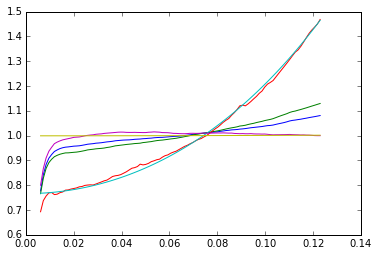

In [993]:
#plt.plot(z, vertical_profile(uv))

plt.plot(z, vertical_profile(bandpass(r.U[:, :, :3000], 0.0, axis=-1)))
plt.plot(z, vertical_profile(bandpass(r.U[:, :, :3000], 0.6, axis=-1)))
plt.plot(z, vertical_profile(bandpass(r.U[:, :, :3000], 1.5, axis=-1)))


plt.plot(z, vu(z, n=18))

plt.plot(z, vertical_profile(bandpass(r.U[:, :, :3000], 0.0, 0.2, axis=-1)))
plt.plot(z, vu(z, n=1))

0.54463008162918836

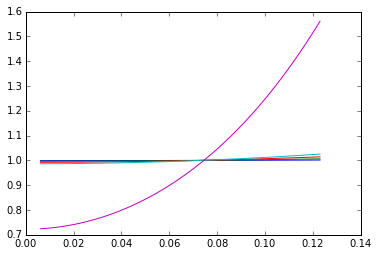

In [1400]:
plt.plot(z, vu(z, n=1))
plt.plot(z, vu(z, n=2))
plt.plot(z, vu(z, n=3))
plt.plot(z, vu(z, n=4))

plt.plot(z, vu(z, n=20))
full_frequency(4)

Can't just use double dct because the vertical profile has a kink at the bottom (shear layer) that is not picked up very well by cosine.

Could do it by frequency band. Not sure how well this will work though. Something like this:

how do we define vprof?

is it just like the theory with a shear layer at the bottom?

how do we model this?

shear layer depth depends on the wavelength

need to model it because we don't have sufficient data to do otherwise: not all frequencies are well represented.

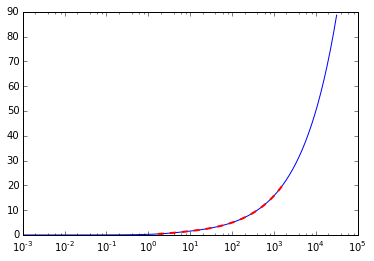

In [1041]:
# first need to invert the frequency to get k given f

def standing_frequency(k):
    g = 9.81
    H = 0.25
    w2 = g * k * np.tanh(k * H)
    return w2 ** .5 / (2 * np.pi)

k = np.hstack(([0], np.logspace(-3, 4.5, 100)))
plt.plot(k, standing_frequency(k))

k_lookup = interp.interp1d(standing_frequency(k), k)
f = np.linspace(0, 20)
plt.semilogx(k_lookup(f), f, 'r--', linewidth=2)

In [1959]:
# now define a function that computes the vertical profile for given z, f
def vprof(z, freq, norm=True):
    H = 0.25
    k = k_lookup(freq)
    v = np.cosh(z * k) / np.sinh(k * H)
    if norm:
        return v / v.max(axis=0)
    else:
        return v

# and create an interpolator for this that can handle the f = 0 case
freqs = np.hstack(([0], np.linspace(0.05, 20, 100)))

profile = vprof(z[:, None], freqs[1:])
print profile.shape
profile = np.hstack((np.ones(z.size)[:, None], profile))
print profile.shape

print z.shape
print freqs.shape
iprofile = interp.RectBivariateSpline(z, freqs, profile)

(102, 100)
(102, 101)
(102,)
(101,)


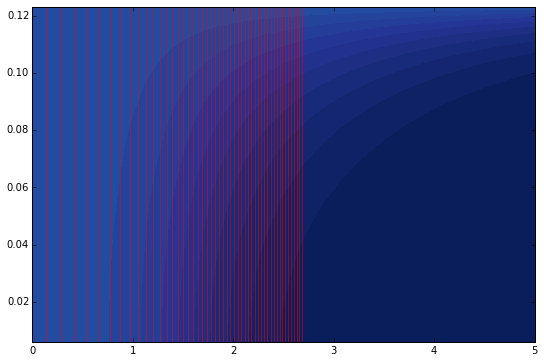

In [1960]:
Z, F = np.meshgrid(z, freqs, indexing='ij')

plt.figure(figsize=(9, 6))
plt.contourf(F, Z, iprofile(z, freqs), levels=np.linspace(-0.00001, 5))

plt.xlim(0, 5)

plot_all_frequencies(50, color='r', alpha=0.5)

What we're seeing here is the transition from shallow to deep water approx. In extreme shallow water, the wave occupies the full depth; in extreme deep water, the wave is confined to the surface.

This also gives us an a priori idea of the frequency at which standing waves will cease to be a problem throughout the fluid. Below 2.5Hz, the waves can be said to affect the full fluid depth; above 20Hz, waves are clearly in the very deep water regime with energy confined to the surface.

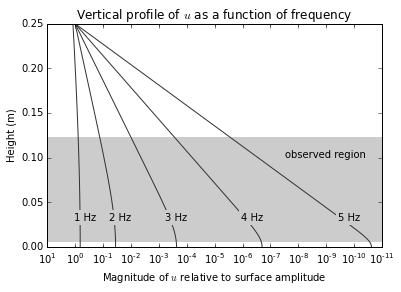

In [1289]:
plt.title('Vertical profile of $u$ as a function of frequency')

plt.ylabel('Height (m)')
plt.xlabel('Magnitude of $u$ relative to surface amplitude')

zz = np.linspace(0, 0.25, 100)

for f in np.arange(1, 6):
    plt.semilogx(vprof(zz, f, norm=False), zz, color='0.2')
    plt.text(vprof(0.03, f, norm=False) * 1.6, 0.03, str(f) + ' Hz', bbox=dict(fc='0.8', ec='0.8'))

plt.axhspan(z.min(), z.max(), color='0.8')
plt.text(3e-8, 0.1, 'observed region')

plt.gca().invert_xaxis()

Clearly the wave energy becomes increasingly concentrated at the surface layer as the frequency increases. Above 3Hz, we expect wave amplitudes $10^{-3}$ the size of the surface amplitude.

This doesn't necessarily mean that these higher frequencies will be insignificant in our signal: there could be a strong projection of the wave forming disturbance onto higher frequencies. The power spectrum of the uppermost layer of the observed region does not bear this out though - frequency content drops off significantly above 3Hz.

(0.05, 10)

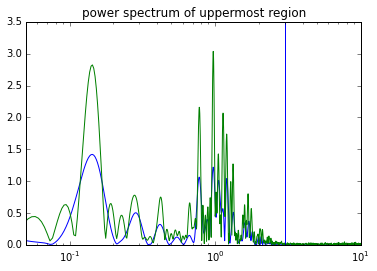

In [1576]:
plt.title('power spectrum of uppermost region')

plot_smooth_fft(r.U[-1, :, :3000].mean(axis=0))
plot_smooth_fft(r.U[-1, 0, :3000], window='boxcar')

plt.axvline(3)

plt.xlim(0.05, 10)

In [2009]:
# create waves that capture the x variance from a mean over z
xwaves = dct_waves(index=2, signal=r.U[:, :, 300:3300].mean(axis=0), cutoff=0.6)

# take an fft over time
xfft = np.fft.rfft(xwaves, axis=-1)
xfreqs = np.fft.rfftfreq(xwaves.shape[-1], d=0.01)

fhi = 3
ihi = np.abs(xfreqs - fhi).argmin()

flo = 0.05
ilo = np.abs(xfreqs - flo).argmin()
print ilo, ihi
print xfreqs[ilo], xfreqs[ihi]

# extend the fft over vertical by multiplying by vertical profile that varies with frequency
#zxfft = xfft[None, :, :] * iprofile(z, xfreqs)[:, None, :]
#zxfft[:, :, :18] = 0
#zxfft[:, :, 599:] = 0

zxfft = xfft[None, :, :] * np.ones((z.size, 1, 1))
zxfft[:, :, ilo:ihi] = zxfft[:, :, ilo:ihi] * iprofile(z, xfreqs)[:, None, ilo:ihi]  # addresses todo below
print xfft.shape
print zxfft.shape

# alternate way here: multiply iprofile by butterworth bandpass that tapers to unity

# TODO: might want to restruct the frequency range in which we 
# are multiplying by the vertical profile, with ones outside (or some smooth transition).
# Why? because of the finite signal - we have to represent the edges somehow, and they 
# need a broadband of frequencies.
# Perhaps use a butterworth shape band filter to delineate the frequency region.
# That way we don't get ringing.

# compute the inverse fft
zxwaves = np.fft.irfft(zxfft, axis=-1)

2 90
0.0666666666667 3.0
(110, 1501)
(102, 110, 1501)


<matplotlib.colorbar.Colorbar instance at 0x2af519cd2cf8>

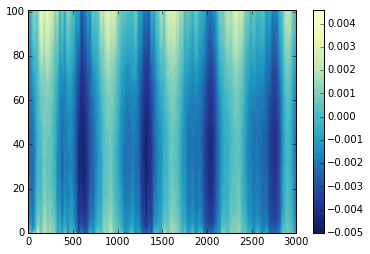

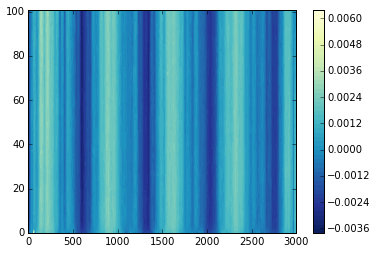

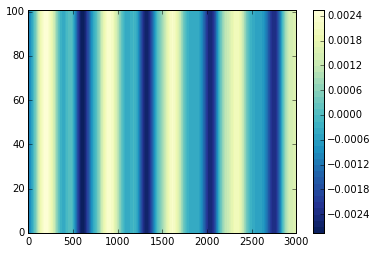

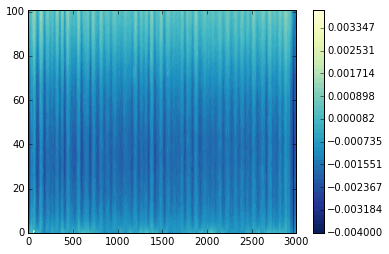

In [2010]:
plt.figure()
#plt.contourf(su[:, :, :3000].mean(axis=1), levels=np.linspace(-0.001, 0.001))
#plt.colorbar()

plt.figure()
plt.contourf((r.U[:, :, 300:3300] - xwaves).mean(axis=1), 50)
plt.colorbar()

plt.figure()
#plt.contourf((r.U[:, :, 300:3300] - zxwaves - decay_waves[:, :3000]).mean(axis=1), levels=np.linspace(-0.001, 0.001))
plt.contourf((r.U[:, :, 300:3300] - r.U[..., 300:3300].mean(axis=1).mean(axis=-1)[:, None, None] - zxwaves).mean(axis=1), 50)
plt.colorbar()

plt.figure()
plt.contourf((decay_waves[None, :, :3000]).mean(axis=1) * np.ones((z.size, 1)), 50)
plt.colorbar()

plt.figure()
plt.contourf((r.U[:, :, 300:3300] -zxwaves).mean(axis=1) - (decay_waves[None, :, :3000]).mean(axis=1) * np.ones((z.size, 1)), levels=np.linspace(-0.004, 0.004))
plt.colorbar()

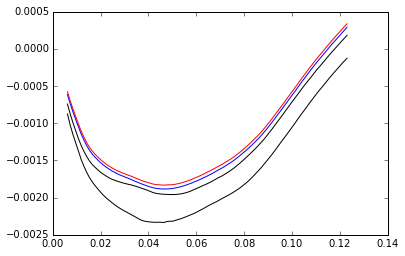

In [1651]:
plt.plot(z, (r.U[:, :, 300:3300] -zxwaves)[..., 500:2500].mean(axis=1).mean(axis=-1))


plt.plot(z, r.U[:, :, 300:3300].mean(axis=1).mean(axis=-1), 'r')

plt.plot(z, r.U[:, :, :1000].mean(axis=1).mean(axis=-1), 'k')
plt.plot(z, r.U[:, :, 2000:3300].mean(axis=1).mean(axis=-1), 'k')

### Determining the boundary layer

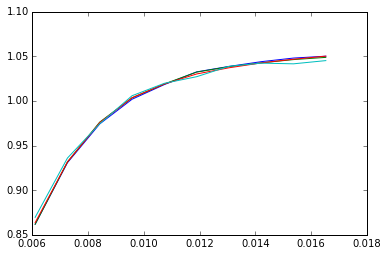

In [1304]:
plt.plot(z[:10], vertical_profile(bandpass(r.U[:10, :, :3000], 0.0, 0.5, axis=-1)))
plt.plot(z[:10], vertical_profile(bandpass(r.U[:10, :, :3000], 0.5, 1.0, axis=-1)))
plt.plot(z[:10], vertical_profile(bandpass(r.U[:10, :, :3000], 1.0, 1.5, axis=-1)))
plt.plot(z[:10], vertical_profile(bandpass(r.U[:10, :, :3000], 1.5, 2.0, axis=-1)))

In [1316]:
def log_boundary(z, ut, d, c):
    return ut * np.log(z / d) + c

opt.curve_fit(log_boundary, z[:10], vertical_profile(bandpass(r.U[:10, :, :3000], 0.0, 1.5, axis=-1)), p0=(1, 0.01, 1))

(array([ 1.  ,  0.01,  1.  ]), array([[ inf,  inf,  inf],
        [ inf,  inf,  inf],
        [ inf,  inf,  inf]]))

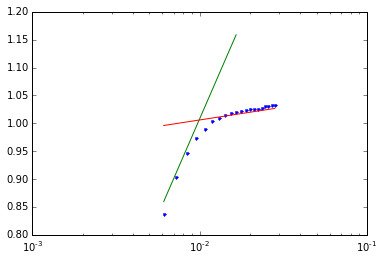

In [1367]:
plt.semilogx(z[:20], vertical_profile(bandpass(r.U[:20, :, :3000], 0.0, 0.5, axis=-1)), '.')

plt.semilogx(z[:10], log_boundary(z[:10], 0.3, 0.005, 0.8))
plt.semilogx(z[:20], log_boundary(z[:20], 0.02, 0.001, 0.96))

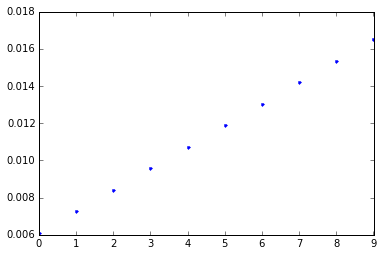

In [1369]:
plt.plot(z[:10], '.')

The boundary layer appears difficult to define. It doesn't follow a log profile, which is not what we naively expect. Might just be easier to **ignore the boundary** - i.e. chop off the lower 5 points.

<matplotlib.contour.QuadContourSet instance at 0x2af634a1ca70>

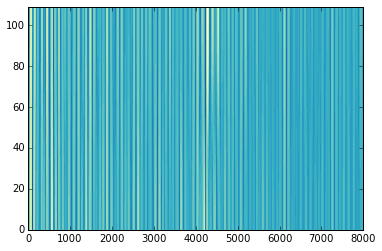

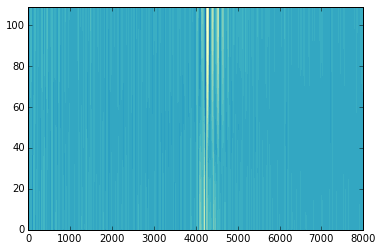

In [1409]:
upper_waves = dct_waves(index=3, signal=valid_mean_subtracted[-10:].mean(axis=0))

plt.contourf(upper_waves, 50)

plt.figure()
plt.contourf(upper_waves - dct_waves(3), 50)

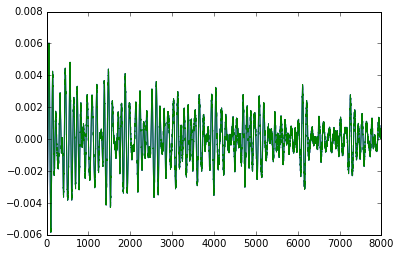

In [1411]:
plt.plot(dct_waves(2).mean(axis=0))
plt.plot(dct_waves(3).mean(axis=0))

<matplotlib.colorbar.Colorbar instance at 0x2af6385fb998>

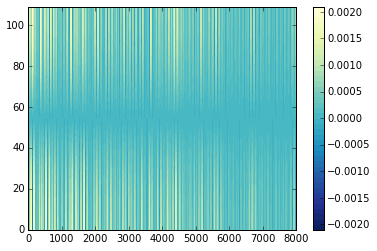

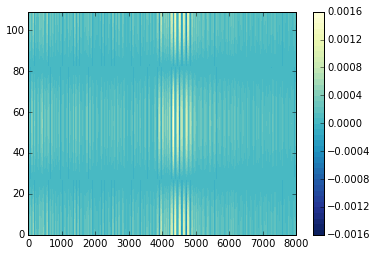

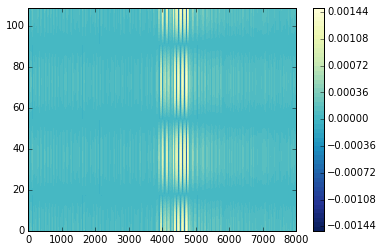

In [1416]:
plt.contourf(dct_waves(1) - dct_waves(2), 50)
plt.colorbar()

plt.figure()
plt.contourf(dct_waves(2) - dct_waves(3), 50)
plt.colorbar()

plt.figure()
plt.contourf(dct_waves(3) - dct_waves(4), 50)
plt.colorbar()

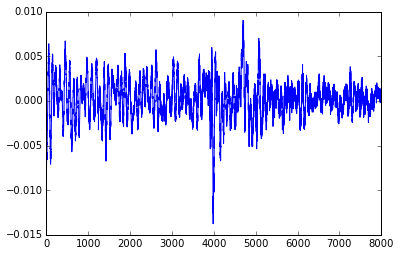

In [1417]:
plt.plot(valid_mean_subtracted[20, 30, :])

<matplotlib.colorbar.Colorbar instance at 0x2af7c8083b48>

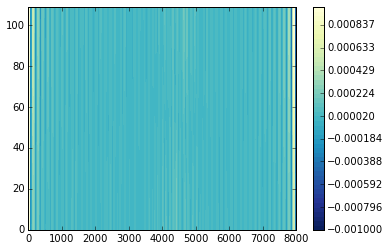

In [1419]:
plt.figure()
plt.contourf(dct_waves(2) - dct_waves(2, signal=r.U[..., 300:8300].mean(axis=0)), levels=np.linspace(-0.001, 0.001))
plt.colorbar()

(3, 15)

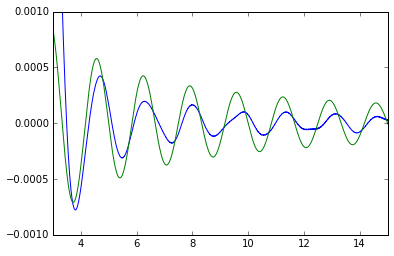

In [1437]:
t = r.T[0, 0, 300:8300]

plt.plot(t, (dct_waves(2, cutoff=0.6) - dct_waves(2, cutoff=0.6, signal=r.U[..., 300:8300].mean(axis=0))).mean(axis=0))
plt.plot(t, -0.01 * np.sinc(1.2 * t))


plt.ylim(-0.001, 0.001)
plt.xlim(3, 15)

In [1991]:
def brickpass(signal, cutoff, high_cutoff=False, axis=-1):
    """Brick wall filter"""
    fft = np.fft.rfft(signal, axis=axis)
    freqs = np.fft.rfftfreq(signal.shape[axis], d=0.01)
    
    s = [slice(None) for _ in range(signal.ndim)]
    s[axis] = freqs < cutoff
    rfft = fft.copy()
    rfft[s] = 0
    
    if high_cutoff:
        s[axis] = freqs > high_cutoff
        rfft[s] = 0
        
    rdata = np.fft.irfft(rfft, axis=axis)
    return rdata

def butterpass(signal, cutoff, high_cutoff=False, axis=-1, order=3):
    """Butterworth filter"""
    nyq = 50.
    
    high_cutoff = high_cutoff or nyq - 0.00001
    
    low = cutoff / nyq
    high = high_cutoff / nyq
    
    b, a = sig.butter(order, [low, high], btype='bandpass')
    
    # use a forward-backward filter to leave the phase unchanged
    return sig.filtfilt(b, a, signal, axis=axis)

def fbutterpass(signal, cutoff, high_cutoff=False, axis=-1, order=2):
    """Butterworth filter in frequency domain"""
    fft = np.fft.rfft(signal, axis=axis)
    freqs = np.fft.rfftfreq(signal.shape[axis], d=0.01)
    
    s = [None for _ in range(signal.ndim)]
    s[axis] = slice(None)
    
    n = 2 * order
    
    if cutoff == 0:
        lo_butter = np.ones(freqs.size)
    else:
        lo_butter = 1 - (1 / (1 + (freqs / cutoff) ** n))
        
    if not high_cutoff:
        hi_butter = np.ones(freqs.size)
    else:
        hi_butter = (1 / (1 + (freqs / high_cutoff) ** n))

    rfft = fft * lo_butter[s] * hi_butter[s]
    rdata = np.fft.irfft(rfft, axis=axis)
    return rdata

In [1474]:
u = all_waves.mean(axis=0)

0.012 0.9999998


(-0.01, 0.01)

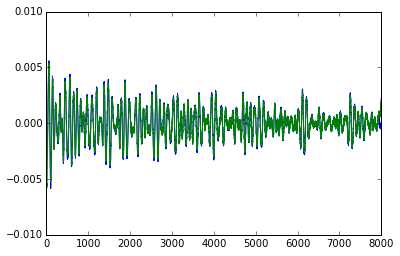

In [1992]:
#plt.plot(u)
#plt.plot(brickpass(u, 0.6))
plt.plot(butterpass(u, 0.6))
plt.plot(fbutterpass(u, 0.6))

plt.ylim(-0.01, 0.01)
#plt.xlim(4000, 6000)

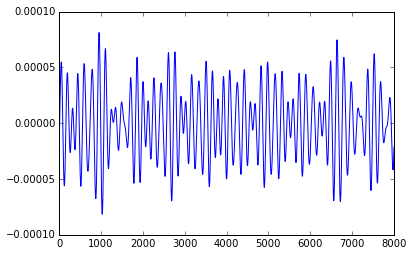

In [2005]:
plt.plot(brickpass(u, 0.6) - fbutterpass(u, 0.6, order=8))

0.012 0.9999998


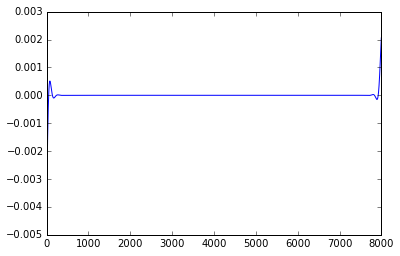

In [2001]:
plt.plot(fbutterpass(u, 0.6, order=3) - butterpass(u, 0.6, order=3))

0.012 0.9999998


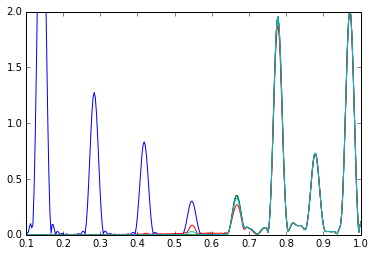

In [1996]:
plot_smooth_fft(u)
plot_smooth_fft(brickpass(u, 0.6))
plot_smooth_fft(butterpass(u, 0.6, order=6))
plot_smooth_fft(fbutterpass(u, 0.6, order=12))

plt.ylim(0, 2)
plt.xlim(0.1, 1)
plt.xscale('linear')

<matplotlib.colorbar.Colorbar instance at 0x2af509cd0c68>

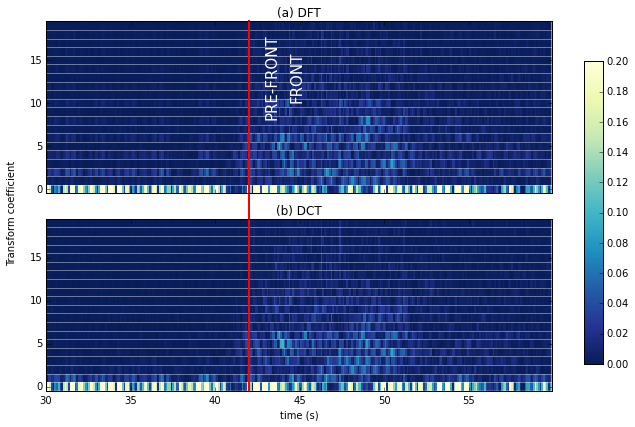

In [1928]:
cutoff = 0.6
dct = fftpack.dct(bandpass(r.U[:].mean(axis=0), cutoff), axis=0) / 2
dft = fftpack.rfft(bandpass(r.U[:].mean(axis=0), cutoff), axis=0)

xf = np.fft.rfftfreq(x.size, d=np.diff(x)[0])
xi = np.arange(xf.size)
XF, TF = np.meshgrid(xi, time, indexing='ij')
where = np.s_[:20, 3000:6000:10]

extent = (TF[where].min(), TF[where].max(), XF[where].min() - 0.5, XF[where].max() + 0.5)

upper = 0.2

fig, ax = plt.subplots(nrows=2, figsize=(9, 6), sharex=True, sharey=True)

im0 = ax[0].imshow(np.abs(dft[where]), extent=extent, aspect='auto', vmin=0, vmax=upper, interpolation='none', origin='lower left')
im1 = ax[1].imshow(np.abs(dct[where]), extent=extent, aspect='auto', vmin=0, vmax=upper, interpolation='none', origin='lower left')

for i in xi[where[0]]:
    ax[0].axhline(i - 0.5, color='w', alpha=0.4)
    ax[1].axhline(i - 0.5, color='w', alpha=0.4)

fig.text(0.01, 0.5, 'Transform coefficient', va='center', rotation='vertical')

ax[0].axvline(42, ymin=-1, ymax=1, color='r', linewidth=2, clip_on=False)
ax[1].axvline(42, ymin=0, ymax=1, color='r', linewidth=2, clip_on=False)

ax[0].text(43, 13, 'PRE-FRONT', color='w', fontsize=15, va='center', rotation='vertical')
ax[0].text(44.5, 13, 'FRONT', color='w', fontsize=15, va='center', rotation='vertical')


ax[0].set_title('(a) DFT')
ax[1].set_title('(b) DCT')
ax[1].set_xlabel('time (s)')

fig.tight_layout()
   
fig.subplots_adjust(right=0.85, left=0.07)
cax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
fig.colorbar(im0, cax=cax)

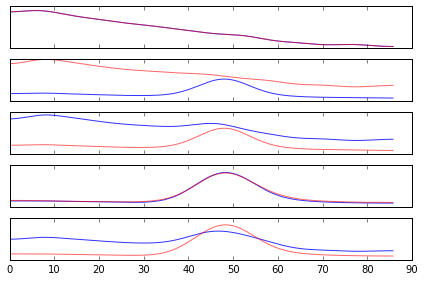

In [1926]:
from functools import partial

smooth = partial(ndi.gaussian_filter1d, sigma=500)
time = r.T[0, 0, :]
ni = 5
fig, axes = plt.subplots(nrows=ni, sharex=True)
for i in range(ni):
    axes[i].plot(time, smooth(np.abs(dft[i])), alpha=0.8)
    axes[i].plot(time, smooth(np.abs(dct[i])), alpha=0.6, color='r')
    axes[i].set_yticks(())
    
fig.tight_layout()

In [1925]:
t.shape

(8000,)

(0, 0.04)

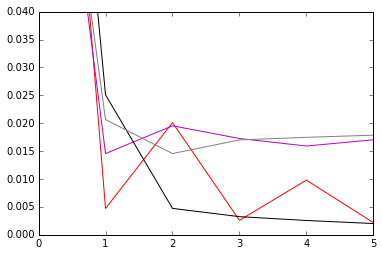

In [1891]:
plt.plot(smoooth(np.abs(dft[:, 2000:4000]).mean(axis=1)), 'r')
plt.plot(smooth(np.abs(dft[:, 4000:6000]).mean(axis=1), 'm')

plt.plot(np.abs(dct[:, 2000:4000]).mean(axis=1), 'k')
plt.plot(np.abs(dct[:, 4000:6000]).mean(axis=1), 'gray')
plt.xlim(0, 5)
plt.ylim(0, 0.04)